<a href="https://colab.research.google.com/github/rwanalramli/BigData-StockPrediction/blob/main/Amazon_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# تثبيت pyspark
!pip install pyspark

# استيراد المكتبات
from pyspark.sql import SparkSession

# إنشاء Spark Session
spark = SparkSession.builder \
    .appName("AmazonStockAnalysis") \
    .getOrCreate()

print("✅ Spark is ready!")


✅ Spark is ready!


In [2]:
from google.colab import drive
import os
from pyspark.sql import SparkSession

# ربط Google Drive
drive.mount('/content/drive')

# إنشاء Spark Session
spark = SparkSession.builder.appName("AmazonStockAnalysis").getOrCreate()

folder_path = "/content/drive/MyDrive/AmazonData"

# قراءة كل ملفات CSV داخل الفولدر
df = spark.read.csv(
    os.path.join(folder_path, "*.csv"),
    header=True,
    inferSchema=True
)

# عرض أول 5 أسطر للتأكد
df.show(5)

# عدد الصفوف الكلي
print("Total rows:", df.count())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------+
|               date|               open|               high|                low|              close|          adj_close|    volume|
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------+
|               NULL|               AMZN|               AMZN|               AMZN|               AMZN|               AMZN|      AMZN|
|1997-05-15 00:00:00|0.12187500298023224|              0.125|0.09635400027036667|0.09791699796915054|0.09791699796915054|1443120000|
|1997-05-16 00:00:00|0.09843800216913223|0.09895800054073334| 0.0854170024394989| 0.0864579975605011| 0.0864579975605011| 294000000|
|1997-05-19 00:00:00|0.08802100270986557|0.08854199945926666|0.0812499970

In [3]:
from pyspark.sql import functions as F



#  لإعادة التسمية
rename_map = {
    "date":"Date", "Date":"Date",
    "open":"Open","open|AMZN":"Open","Open":"Open",
    "high":"High","high|AMZN":"High","High":"High",
    "low":"Low","low|AMZN":"Low","Low":"Low",
    "close":"Close","close|AMZN":"Close","Close":"Close",
    "adj close":"Adj_Close","Adj Close":"Adj_Close","Adj_Close":"Adj_Close","adj_close":"Adj_Close",
    "volume":"Volume","volume|AMZN":"Volume","Volume":"Volume",
    "ticker":"Ticker","symbol":"Ticker","Symbol":"Ticker","Ticker":"Ticker"
}

for c in list(df.columns):
    key = c.strip()
    if key in rename_map and c != rename_map[key]:
        df = df.withColumnRenamed(c, rename_map[key])

# تحويل التاريخ (لو كان نص) إلى تاريخ
df = df.withColumn("Date", F.to_date("Date"))

# تحويل الأعمدة الرقمية إلى Double
num_cols = [c for c in ["Open","High","Low","Close","Adj_Close","Volume"] if c in df.columns]
for c in num_cols:
    df = df.withColumn(c, F.col(c).cast("double"))
# إسقاط الصفوف الفارغة تمامًا
df = df.na.drop(how="any")

# ترتيب الأعمدة النهائية (حسب المتوفّر)
final_cols = ["Date"] + [c for c in ["Open","High","Low","Close","Adj_Close","Volume","Ticker"] if c in df.columns]
df = df.select(*final_cols).orderBy("Date")

df.show(5)
print("Rows:", df.count(), "| Cols:", len(df.columns))


+----------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|      Date|               Open|               High|                Low|              Close|          Adj_Close|   Volume|
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|1997-05-15|0.12187500298023224|              0.125|0.09635400027036667|0.09791699796915054|0.09791699796915054|1.44312E9|
|1997-05-16|0.09843800216913223|0.09895800054073334| 0.0854170024394989| 0.0864579975605011| 0.0864579975605011|   2.94E8|
|1997-05-19|0.08802100270986557|0.08854199945926666|0.08124999701976776| 0.0854170024394989| 0.0854170024394989|1.22136E8|
|1997-05-20| 0.0864579975605011|0.08749999850988388|0.08177100121974945|0.08177100121974945|0.08177100121974945|1.09344E8|
|1997-05-21|0.08177100121974945|0.08229199796915054|0.06875000149011612|0.07135400176048279|0.07135400176048279|3.77064E8|
+----------+----

In [4]:
from pyspark.sql import functions as F

df.printSchema()
print("Rows:", df.count(), "| Cols:", len(df.columns))

# نطاق التواريخ وو عدد الأسهم (لو عمود Ticker)
date_min, date_max = df.select(F.min("Date"), F.max("Date")).first()
print("Date range:", date_min, "→", date_max)
if "Ticker" in df.columns:
    print("Tickers:", df.select("Ticker").distinct().count())

# إحصائيات وصفية للأعمدة الرقمية
num_cols = [c for c,t in df.dtypes if t in ("int","bigint","double","float") and c != "label"]
df.select(num_cols).describe().show()

# قيم مفقودة لكل عمود
na_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
na_counts.show()


root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj_Close: double (nullable = true)
 |-- Volume: double (nullable = true)

Rows: 20177 | Cols: 7
Date range: 1997-05-15 → 2025-09-12
+-------+------------------+-------------------+-------------------+------------------+------------------+-------------------+
|summary|              Open|               High|                Low|             Close|         Adj_Close|             Volume|
+-------+------------------+-------------------+-------------------+------------------+------------------+-------------------+
|  count|             20177|              20177|              20177|             20177|             20177|              20177|
|   mean| 71.65917262258748|  72.48375084223434|  70.76036540243501| 71.64615558279509| 71.64615558279509| 9.52472917827229E7|
| stddev| 65.56741043050017|   66.3186410087

In [5]:
from pyspark.sql.window import Window

w = Window.orderBy("Date")
df_feat = (df
  .withColumn("Return", (F.col("Close") - F.lag("Close").over(w)) / F.lag("Close").over(w))
  .withColumn("MA_5",  F.avg("Close").over(w.rowsBetween(-4,0)))
  .withColumn("MA_20", F.avg("Close").over(w.rowsBetween(-19,0)))
  .dropna()
)

feat_cols = [c for c in ["Open","High","Low","Close","Adj_Close","Volume","Return","MA_5","MA_20"] if c in df_feat.columns]

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vec = VectorAssembler(inputCols=feat_cols, outputCol="features_corr").transform(df_feat)
corr_mat = Correlation.corr(vec, "features_corr", "pearson").head()[0].toArray()

import pandas as pd, numpy as np
corr_df = pd.DataFrame(corr_mat, index=feat_cols, columns=feat_cols)
corr_df.round(3)


,Open,High,Low,Close,Adj_Close,Volume,Return,MA_5,MA_20
Open,1.000,1.000,1.000,1.000,1.000,-0.297,-0.021,1.000,1.000
High,1.000,1.000,1.000,1.000,1.000,-0.295,-0.019,1.000,1.000
Low,1.000,1.000,1.000,1.000,1.000,-0.299,-0.019,1.000,0.999
Close,1.000,1.000,1.000,1.000,1.000,-0.297,-0.018,1.000,0.999
Adj_Close,1.000,1.000,1.000,1.000,1.000,-0.297,-0.018,1.000,0.999
Volume,-0.297,-0.295,-0.299,-0.297,-0.297,1.000,0.152,-0.297,-0.297
Return,-0.021,-0.019,-0.019,-0.018,-0.018,0.152,1.000,-0.022,-0.023
MA_5,1.000,1.000,1.000,1.000,1.000,-0.297,-0.022,1.000,1.000
MA_20,1.000,1.000,0.999,0.999,0.999,-0.297,-0.023,1.000,1.000


In [6]:
split_ratio = 0.8
n = df_feat.count()
cut = int(n * split_ratio)
split_date = (df_feat.select("Date").orderBy("Date").rdd.map(lambda r: r["Date"]).collect())[cut]

train = df_feat.filter(F.col("Date") <= split_date).cache()
test  = df_feat.filter(F.col("Date") > split_date).cache()

print("Train:", train.count(), "| Test:", test.count(), "| Split at:", split_date)

label_col = "Close"
feature_cols = [c for c in feat_cols if c != label_col]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_v = assembler.transform(train).select("features", F.col(label_col).alias("label"))
test_v  = assembler.transform(test).select("features", F.col(label_col).alias("label"))

train_v.cache()
test_v.cache()
print("✅ Done:", train_v.count(), test_v.count())


Train: 16143 | Test: 4033 | Split at: 2022-03-17
✅ Done: 16143 4033


In [7]:
# === كل ما يلزم لتحضير train_v / test_v في خلية واحدة ===
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler

# 0) نفترض أن df موجود (مقروء من CSV سابقاً). إن لم يكن، اقريه قبل هذه الخلية.

# 1) تنظيف/توحيد الأعمدة الأساسية (تجاهلي إذا كنتِ عاملاها قبل)
# df = df.dropna(how="any")  # اختياري إذا كنتِ خلّيتي الـ NAs صفر

# 2) ميزات بسيطة (Return, MA_5, MA_20) إن لم تكن موجودة
w = Window.orderBy("Date")
cols_now = set(c.lower() for c in df.columns)
df_feat = df

if "return" not in cols_now and "close" in df.columns:
    df_feat = df_feat.withColumn("Return", (F.col("Close") - F.lag("Close").over(w)) / F.lag("Close").over(w))
if "ma_5" not in cols_now and "close" in df.columns:
    df_feat = df_feat.withColumn("MA_5", F.avg("Close").over(w.rowsBetween(-4, 0)))
if "ma_20" not in cols_now and "close" in df.columns:
    df_feat = df_feat.withColumn("MA_20", F.avg("Close").over(w.rowsBetween(-19, 0)))

df_feat = df_feat.dropna()

# 3) الأعمدة المرشّحة كميزات
feat_cols = [c for c in ["Open","High","Low","Volume","Return","MA_5","MA_20"] if c in df_feat.columns]

# 4) الهدف
label_col = "Close"  # أو "Adj_Close" إذا بدّك

# 5) تقسيم زمني 80/20
split_ratio = 0.8
n = df_feat.count()
cut = int(n * split_ratio)
split_date = (df_feat.select("Date").orderBy("Date").rdd.map(lambda r: r["Date"]).collect())[cut]

train = df_feat.filter(F.col("Date") <= split_date).cache()
test  = df_feat.filter(F.col("Date")  > split_date).cache()
print("Split at:", split_date, "| Train:", train.count(), "| Test:", test.count())

# 6) VectorAssembler → (features, label)
assembler = VectorAssembler(inputCols=feat_cols, outputCol="features")
train_v = assembler.transform(train).select("features", F.col(label_col).alias("label"))
test_v  = assembler.transform(test ).select("features", F.col(label_col).alias("label"))

train_v.cache(); test_v.cache()
print("Prepared:", train_v.count(), test_v.count())



Split at: 2022-03-17 | Train: 16144 | Test: 4033
Prepared: 16144 4033


In [8]:
import time
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# مش معرّفة من قبل:
eval_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
eval_r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

lr = LinearRegression(featuresCol="features", labelCol="label")

t0 = time.time()
lr_model = lr.fit(train_v)              # ✅ استخدم train_v
lr_pred  = lr_model.transform(test_v)   # ✅ استخدم test_v
lr_time  = time.time() - t0

lr_rmse = eval_rmse.evaluate(lr_pred)
lr_r2   = eval_r2.evaluate(lr_pred)

print(f"[LinearRegression] RMSE={lr_rmse:.4f} | R2={lr_r2:.4f} | Time_s={lr_time:.3f}")


[LinearRegression] RMSE=1.0916 | R2=0.9993 | Time_s=13.791


In [9]:
from pyspark.ml.regression import DecisionTreeRegressor
import time

dt = DecisionTreeRegressor(
    featuresCol="features", labelCol="label",
    maxDepth=12, minInstancesPerNode=5, seed=42
)

t0 = time.time()
dt_model = dt.fit(train_v)           # train_v
dt_pred  = dt_model.transform(test_v) # test_v
dt_time  = time.time() - t0

dt_rmse = eval_rmse.evaluate(dt_pred)
dt_r2   = eval_r2.evaluate(dt_pred)

print(f"[DecisionTree] RMSE={dt_rmse:.4f} | R2={dt_r2:.4f} | Time_s={dt_time:.3f}")


[DecisionTree] RMSE=16.3260 | R2=0.8437 | Time_s=120.298


In [13]:
# نفس الـ evaluators و train_v / test_v موجودين عندك

from pyspark.ml.regression import RandomForestRegressor
import time

#    أولاً (خفيف) ثم نكبر
rf = RandomForestRegressor(
    featuresCol="features", labelCol="label",
    numTrees=100,          # بدل 200 كبداية
    maxDepth=9,            # بدل 12
    subsamplingRate=0.8,
    featureSubsetStrategy="sqrt",
    seed=42
)

t0 = time.time()
rf_model = rf.fit(train_v)
rf_pred  = rf_model.transform(test_v)
rf_time  = time.time() - t0

rf_rmse = eval_rmse.evaluate(rf_pred)
rf_r2   = eval_r2.evaluate(rf_pred)

print(f"[RandomForest] RMSE={rf_rmse:.4f} | R2={rf_r2:.4f} | Time_s={rf_time:.3f}")


[RandomForest] RMSE=16.1183 | R2=0.8477 | Time_s=501.656


In [14]:
import pandas as pd

results_df = pd.DataFrame([
    {"Model":"LinearRegression", "RMSE":lr_rmse, "R2":lr_r2},
    {"Model":"DecisionTree",     "RMSE":dt_rmse, "R2":dt_r2},
    {"Model":"RandomForest",     "RMSE":rf_rmse, "R2":rf_r2},
])
results_df


,Model,RMSE,R2
0,LinearRegression,1.091591,0.999301
1,DecisionTree,16.325989,0.843735
2,RandomForest,16.118305,0.847686


In [15]:
import pandas as pd

results_list = [
    {"Model": "LinearRegression", "RMSE": lr_rmse, "R2": lr_r2, "Time_S": lr_time},
    {"Model": "DecisionTree", "RMSE": dt_rmse, "R2": dt_r2, "Time_S": dt_time},
    {"Model": "RandomForest", "RMSE": rf_rmse, "R2": rf_r2, "Time_S": rf_time},
]

results_df = pd.DataFrame(results_list)
results_df


,Model,RMSE,R2,Time_S
0,LinearRegression,1.091591,0.999301,13.791328
1,DecisionTree,16.325989,0.843735,120.297958
2,RandomForest,16.118305,0.847686,501.656055


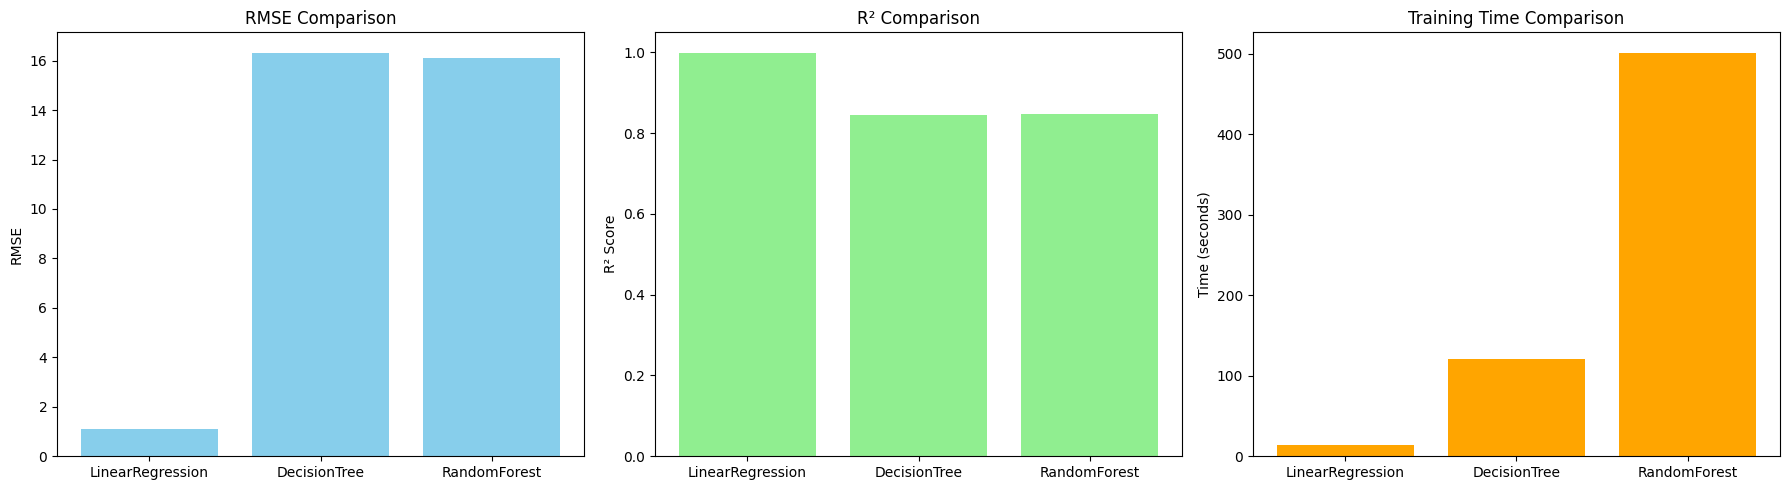

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18,5))  # 1 صف × 3 أعمدة

# ====== RMSE ======
axs[0].bar(results_df["Model"], results_df["RMSE"], color="skyblue")
axs[0].set_title("RMSE Comparison")
axs[0].set_ylabel("RMSE")

# ====== R² ======
axs[1].bar(results_df["Model"], results_df["R2"], color="lightgreen")
axs[1].set_title("R² Comparison")
axs[1].set_ylabel("R² Score")

# ====== Time ======
axs[2].bar(results_df["Model"], results_df["Time_S"], color="orange")
axs[2].set_title("Training Time Comparison")
axs[2].set_ylabel("Time (seconds)")

plt.tight_layout()
plt.show()


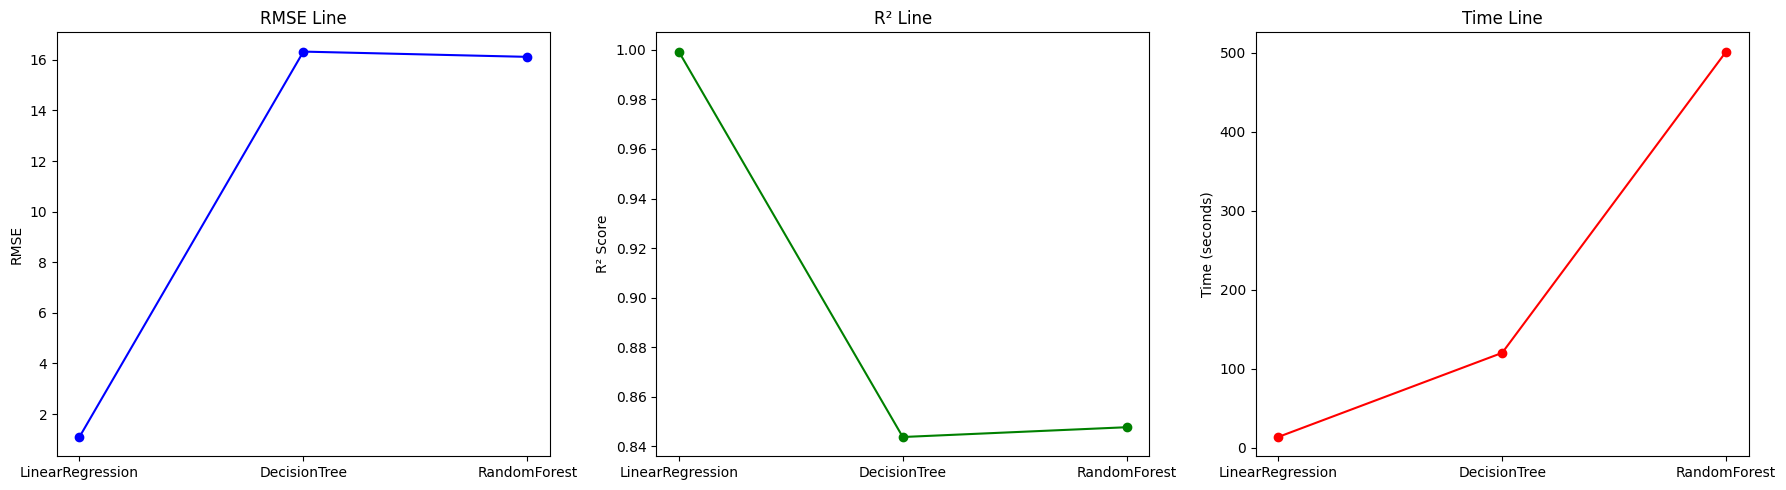

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))  # 1 صف × 3 أعمدة

# ====== RMSE ======
axs[0].plot(results_df["Model"], results_df["RMSE"], marker="o", color="blue")
axs[0].set_title("RMSE Line")
axs[0].set_ylabel("RMSE")

# ====== R² ======
axs[1].plot(results_df["Model"], results_df["R2"], marker="o", color="green")
axs[1].set_title("R² Line")
axs[1].set_ylabel("R² Score")

# ====== Time ======
axs[2].plot(results_df["Model"], results_df["Time_S"], marker="o", color="red")
axs[2].set_title("Time Line")
axs[2].set_ylabel("Time (seconds)")

plt.tight_layout()
plt.show()


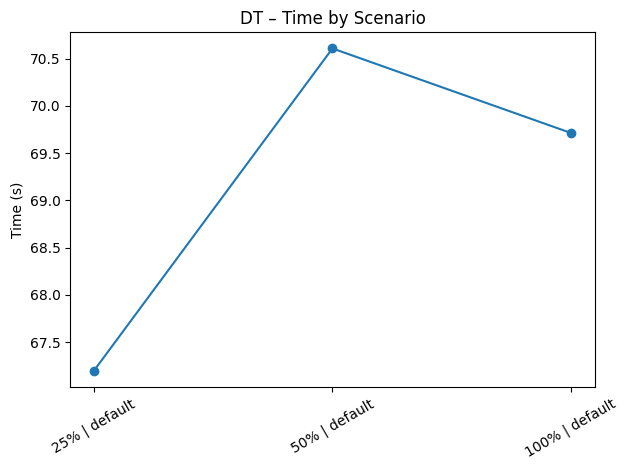

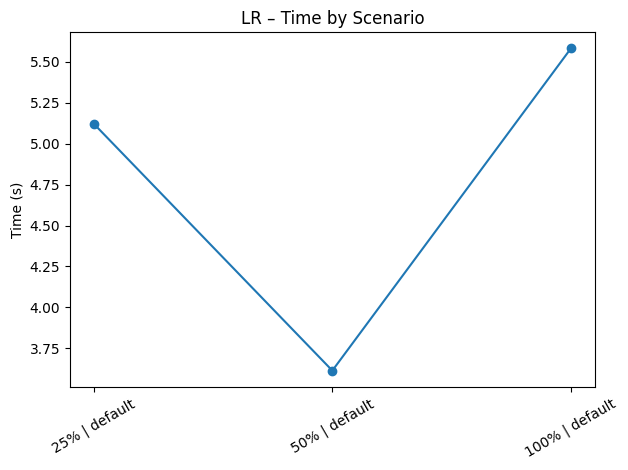

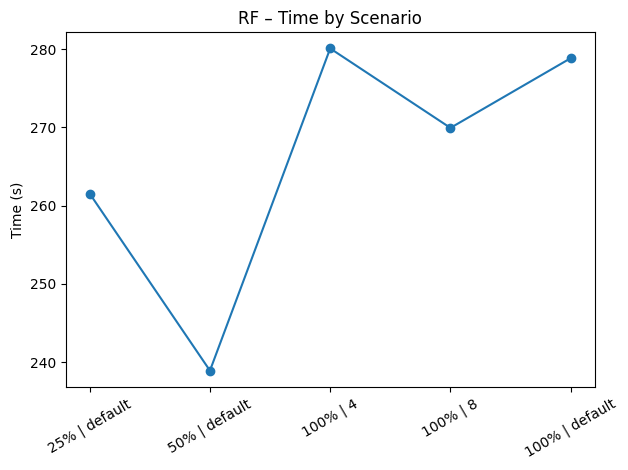

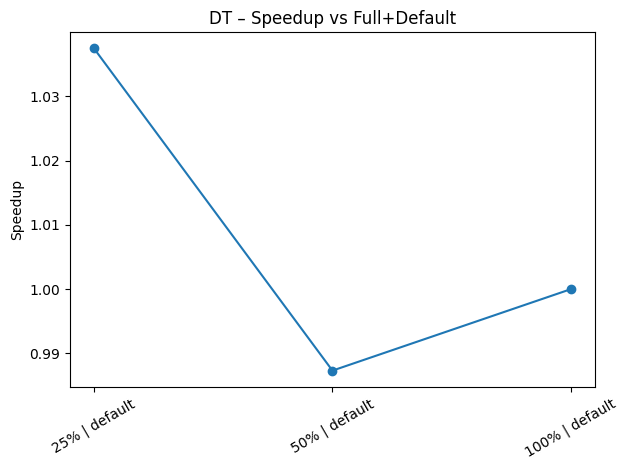

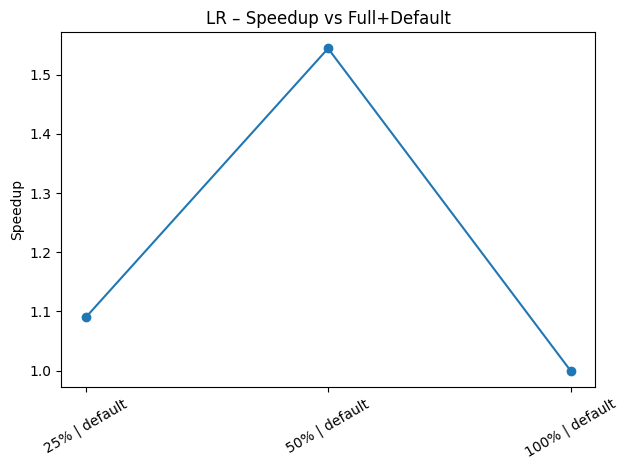

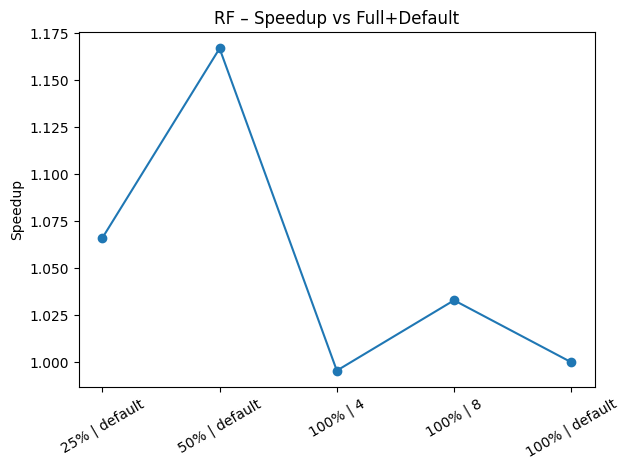

In [27]:
import matplotlib.pyplot as plt

for m in res_df["Model"].unique():
    sub = res_df[res_df["Model"]==m]
    plt.figure()
    plt.title(f"{m} – Time by Scenario")
    plt.plot(range(len(sub)), sub["Time_s"], marker="o")
    plt.xticks(range(len(sub)), [f'{f*100:.0f}% | {p}' for f,p in zip(sub["SampleFrac"], sub["Partitions"])], rotation=30)
    plt.ylabel("Time (s)")
    plt.tight_layout()
    plt.show()

# مخطط للـ Speedup
for m in res_df["Model"].unique():
    sub = res_df[res_df["Model"]==m]
    plt.figure()
    plt.title(f"{m} – Speedup vs Full+Default")
    plt.plot(range(len(sub)), sub["Speedup_vsFullDefault"], marker="o")
    plt.xticks(range(len(sub)), [f'{f*100:.0f}% | {p}' for f,p in zip(sub["SampleFrac"], sub["Partitions"])], rotation=30)
    plt.ylabel("Speedup")
    plt.tight_layout()
    plt.show()


In [31]:
# ثبّت نتائج السبارك باسم واضح
spark_results_df = res_df.copy()

# للتأكد ان الأعمدة موجودة وبأنواع رقمية
need = ["Model","RMSE","R2","Time_s"]
assert all(c in spark_results_df.columns for c in need), spark_results_df.columns
for c in ["RMSE","R2","Time_s"]:
    spark_results_df[c] = pd.to_numeric(spark_results_df[c], errors="coerce")
spark_results_df


,Model,Time_s,RMSE,R2,SampleFrac,Partitions,Speedup_vsFullDefault
0,DT,67.197318,19.968329,0.766232,0.25,default,1.037447
1,DT,70.608566,20.976571,0.742029,0.50,default,0.987326
2,DT,69.713684,16.162551,0.846848,1.00,default,1.000000
3,LR,5.121915,1.095901,0.999296,0.25,default,1.089787
4,LR,3.613842,1.090107,0.999303,0.50,default,1.544561
5,LR,5.581798,1.091591,0.999301,1.00,default,1.000000
6,RF,261.530754,19.037720,0.787513,0.25,default,1.066156
7,RF,238.927358,19.688854,0.772730,0.50,default,1.167019
8,RF,280.075497,16.004290,0.849833,1.00,4,0.995562
9,RF,269.928034,16.004290,0.849833,1.00,8,1.032989


In [32]:
spark_results_df["Model"] = spark_results_df["Model"].replace({
    "LinearRegression": "LinearRegression"  # أو "LinearRegression+Scaled"
})


In [33]:
import os
RESULTS_DIR = "/content/drive/MyDrive/AmazonData/model_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

spark_results_df.to_csv(os.path.join(RESULTS_DIR, "spark_results.csv"), index=False)

print("✅ Spark results saved at:", RESULTS_DIR)


✅ Spark results saved at: /content/drive/MyDrive/AmazonData/model_results
